In [2]:
# Importing the necessary libraries for LSTM Model 
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pandas.core.internals.blocks import soft_convert_objects
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


                 datetime         open         high          low        close
0     2023-03-01 00:00:00  23135.34961  23178.08008  23131.99023  23178.08008
1     2023-03-01 00:05:00  23164.66016  23182.98047  23131.00977  23131.00977
2     2023-03-01 00:10:00  23131.91016  23170.00000  23120.28906  23157.43945
3     2023-03-01 00:15:00  23160.99023  23185.00000  23157.43945  23180.41016
4     2023-03-01 00:20:00  23179.86914  23221.68945  23175.65039  23207.10938
...                   ...          ...          ...          ...          ...
3400  2023-03-12 23:40:00  22022.35938  22065.33984  22022.35938  22053.15039
3401  2023-03-12 23:45:00  22064.55078  22202.58984  22011.86914  22011.86914
3402  2023-03-12 23:50:00  22021.15039  22168.50000  22011.86914  22149.91016
3403  2023-03-12 23:55:00  22131.75000  22223.32031  22131.75000  22199.86914
3404  2023-03-13 00:00:00  22199.86914  22299.53906  22199.86914  22232.98047

[3405 rows x 5 columns]


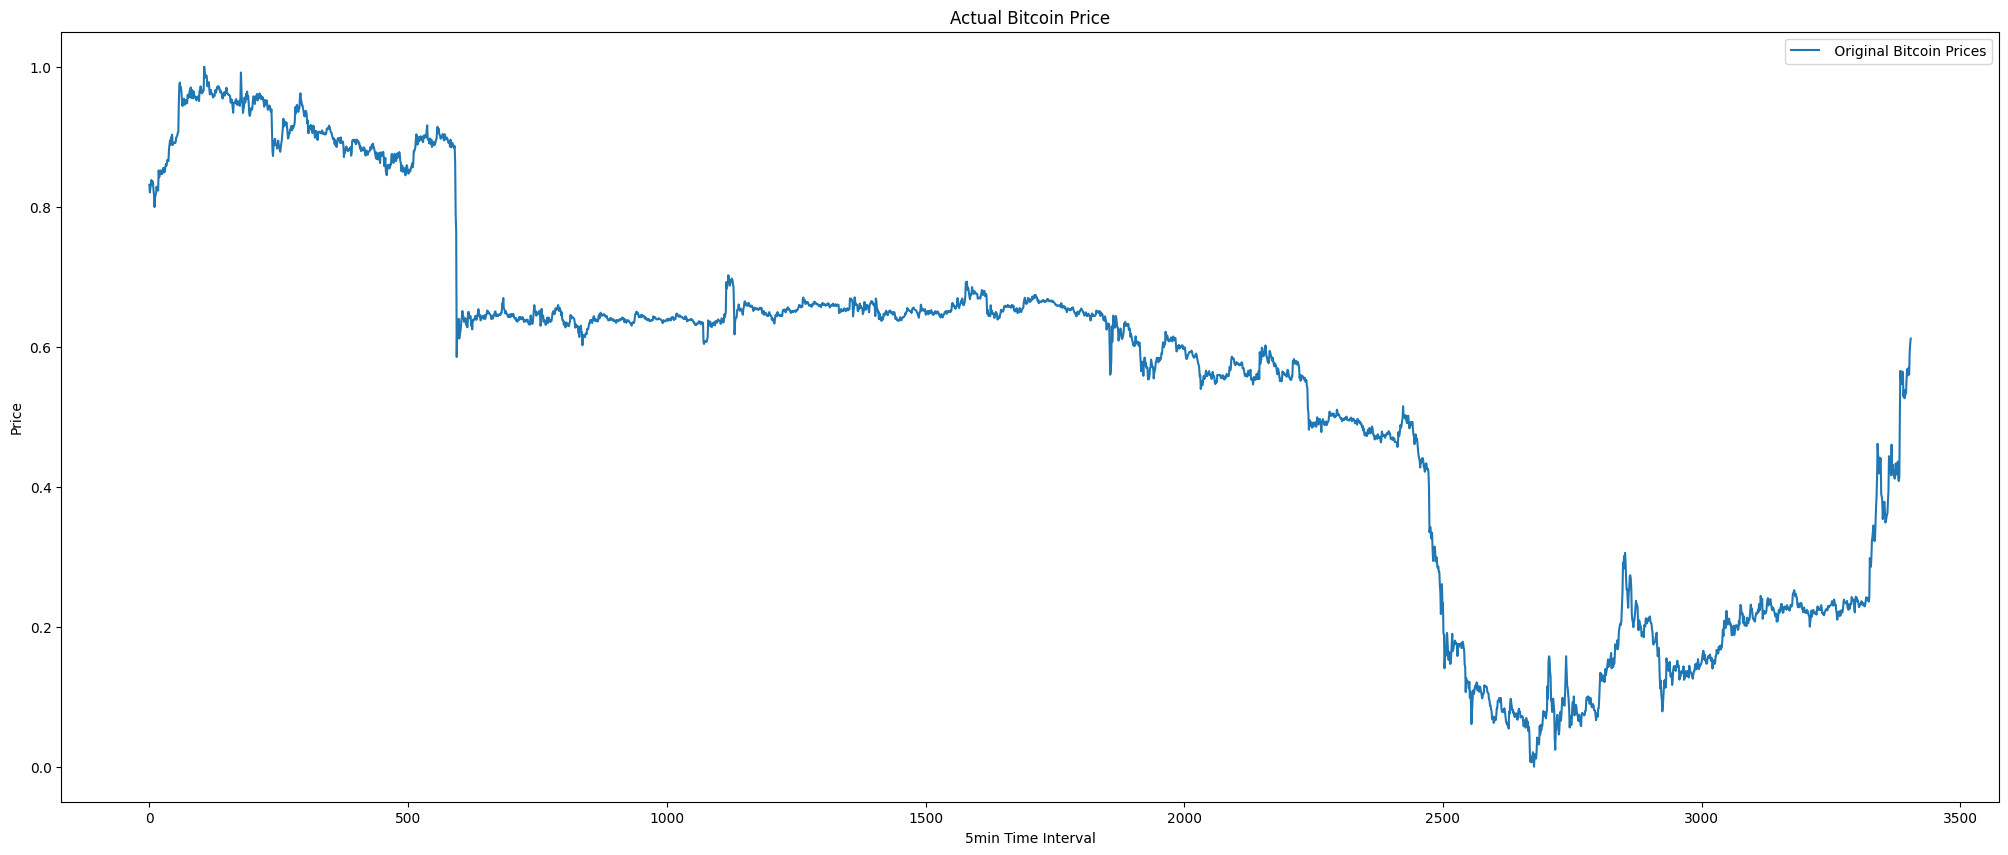

In [3]:
# Setting up a class that can be used for any Model

class Data():
    def __init__(self, api_url):
        self.api_url = api_url
    
    def getting_data(self):
        try:
            data = requests.get(self.api_url).json()
            data_final = pd.DataFrame(data['values'])
            return data_final
        except:
            print("Please check the Parameters in the url are correct.")
    
    def min_max(self, gd):
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(gd['close'].values.reshape(-1,1))
        return scaled_data

    def plot_graph(self, data):
        plt.figure(figsize=(25, 10))
        plt.plot(data, label=' Original Bitcoin Prices')
        plt.title('Actual Bitcoin Price')
        plt.xlabel('5min Time Interval')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# URL parameters
api_key = 'bc815ffa29684289b066eb9f3113c13a'
symbol = 'BTC/USD'
interval = '5min'
order = 'asc'
start_date = '2023-03-01 00:00:00'
end_date = '2023-03-13 00:00:00'
# This is the url of twelve data API 
api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={start_date}&end_date={end_date}&interval={interval}&order={order}&apikey={api_key}'

## Calling the class object
data = Data(api_url)
gd= data.getting_data()
print(gd)
scaled_data = data.min_max(gd)
data.plot_graph(scaled_data)

Epoch 1/10
53/53 [==============================] - 11s 106ms/step - loss: 0.0386 - accuracy: 2.9682e-04
Epoch 2/10
53/53 [==============================] - 5s 93ms/step - loss: 0.0038 - accuracy: 5.9365e-04
Epoch 3/10
53/53 [==============================] - 5s 85ms/step - loss: 0.0029 - accuracy: 5.9365e-04
Epoch 4/10
53/53 [==============================] - 6s 110ms/step - loss: 0.0025 - accuracy: 5.9365e-04
Epoch 5/10
53/53 [==============================] - 5s 87ms/step - loss: 0.0027 - accuracy: 5.9365e-04
Epoch 6/10
53/53 [==============================] - 6s 112ms/step - loss: 0.0025 - accuracy: 5.9365e-04
Epoch 7/10
53/53 [==============================] - 5s 91ms/step - loss: 0.0025 - accuracy: 5.9365e-04
Epoch 8/10
53/53 [==============================] - 5s 86ms/step - loss: 0.0023 - accuracy: 5.9365e-04
Epoch 9/10
53/53 [==============================] - 6s 112ms/step - loss: 0.0022 - accuracy: 5.9365e-04
Epoch 10/10
53/53 [==============================] - 4s 85ms/step - 

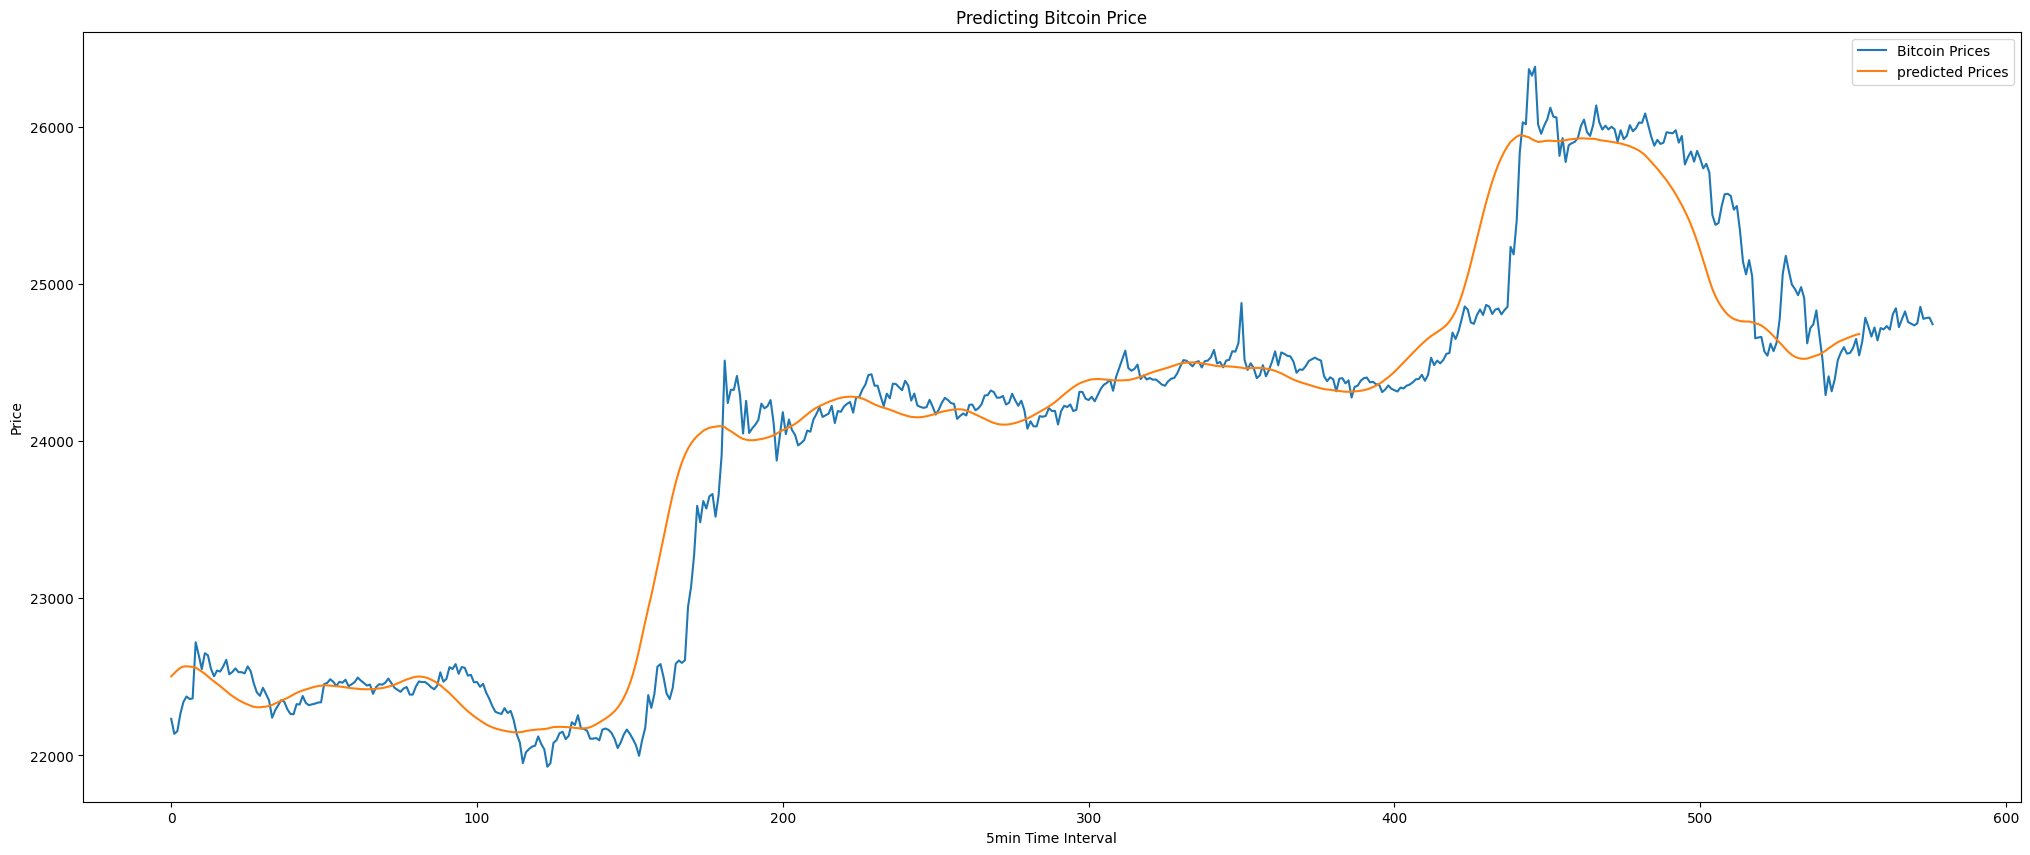

1/1 [==============================] - 1s 949ms/step


array([[24725.088]], dtype=float32)

In [4]:
#Setting up a training class for the model

class Training(Data):
    def __init__(self, api_url, training_interval, prediction_interval):
        super().__init__(api_url)
        self.training_interval = training_interval
        self.prediction_interval = prediction_interval
        self.x_train = []
        self.y_train = []
    
    def prediction(self):
        gd = self.getting_data()
        for i in range(self.training_interval, len(super().min_max(gd))-self.prediction_interval):
            self.x_train.append(super().min_max(gd)[i - self.training_interval: i, 0])
            self.y_train.append(super().min_max(gd)[i + self.prediction_interval, 0])
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1], 1))


    def sequential(self):
      '''Returns the trained LSTM model'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(self.x_train.shape[1], 1), activation='relu'))
        model.add(LSTM(64, return_sequences=True, activation='relu'))
        model.add(Dropout(0.3))
        model.add(LSTM(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
        model.fit(self.x_train, self.y_train, epochs=10, batch_size=64)
        return model
    
    def test_data(self, test_api_url):
        test_data = requests.get(test_api_url).json()
        test_data_final = pd.DataFrame(test_data['values'])    
        self.bitcoin_prices = pd.to_numeric(test_data_final['close'], errors='coerce').values
        test_inputs = test_data_final['close'].values # closing prices
        test_inputs = test_inputs.reshape(-1,1) # reshapin ginto 2 dimensions ot test the data.
        self.scaler = MinMaxScaler()
        model_inputs = self.scaler.fit_transform(test_inputs) #  model innput will have to squeeze the data between 0 and 1. 
        return model_inputs
    
    def make_x_test(self, td):
        x_test = []
        for x in range(self.training_interval, len(td)):
            x_test.append(td[x - self.training_interval:x, 0])
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        print(x_test.shape)
        return x_test  

    def prediction_of_bitcoin_prices(self, td):
        # Create LSTM model using sequential method
        model_seq = self.sequential()
        
        # Generate x_test data
        x_test = self.make_x_test(td)
        
        # Make predictions using the model
        prediction_prices = model_seq.predict(x_test)
        prediction_prices = self.scaler.inverse_transform(prediction_prices)
        prediction_prices = prediction_prices.reshape(prediction_prices.shape[0], -1)    
        return prediction_prices

    def plot_graph( self):
        plt.figure(figsize = (25, 10))
        plt.plot(self.bitcoin_prices, label = 'Bitcoin Prices')
        plt.plot(self.prediction_of_bitcoin_prices(td), label = 'predicted Prices')
        plt.title('Predicting Bitcoin Price')
        plt.xlabel('5min Time Interval')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def predict_next_hour_price(self, fitted_data, td):
        last_data = td[len(td) - self.training_interval:len(td), 0]
        last_data = np.array(last_data)
        last_data = np.reshape(last_data, (1, last_data.shape[0], 1))
        prediction = fitted_data.predict(last_data)
        prediction = self.scaler.inverse_transform(prediction)
        return prediction

# setting up the parameters for the class
test_start = '2023-03-13 00:00:00'
test_end = '2023-03-15 00:00:00'
test_api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={test_start}&end_date={test_end}&interval={interval}&order={order}&apikey={api_key}'

training_interval = 24
prediction_interval = 12

#Class Objects
train = Training(api_url, training_interval,prediction_interval)
train.prediction()
fitted_data = train.sequential()
td = train.test_data(test_api_url)
#print(td)
train.make_x_test(td)
train.prediction_of_bitcoin_prices(td)
train.plot_graph()
train.predict_next_hour_price(fitted_data, td)


In [1]:
""""def predict_next_hour_price(self, fitted_data, td):
        last_data = td[-self.training_interval:]
        last_data = np.array(last_data).reshape(1, -1, 1)
        prediction = fitted_data.predict(last_data)
        prediction = self.scaler.inverse_transform(prediction)
        return prediction[0][0]
train = Training(api_url, training_interval, prediction_interval)
train.prediction()
fitted_data = train.sequential()
td = train.test_data(test_api_url)
next_hour_prediction = train.predict_next_hour_price(fitted_data, td)
print(next_hour_prediction)"""

'"def predict_next_hour_price(self, fitted_data, td):\n        last_data = td[-self.training_interval:]\n        last_data = np.array(last_data).reshape(1, -1, 1)\n        prediction = fitted_data.predict(last_data)\n        prediction = self.scaler.inverse_transform(prediction)\n        return prediction[0][0]\ntrain = Training(api_url, training_interval, prediction_interval)\ntrain.prediction()\nfitted_data = train.sequential()\ntd = train.test_data(test_api_url)\nnext_hour_prediction = train.predict_next_hour_price(fitted_data, td)\nprint(next_hour_prediction)'